In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Model 
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [2]:
#importing data
X = np.load("training_data/sequences.npy")
y = np.load("training_data/labels.npy")

In [3]:
#try scaling for real time performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1657, 30, 1662)
X_test:  (293, 30, 1662)


In [4]:
#logs
log_dir = os.path.join('logs')
tb_callback = TensorBoard(log_dir = log_dir)
# reduceLR_callback = ReduceLROnPlateau(monitor = 'val_loss', min_lr = 1e-5)

In [27]:
#Shuffling dataset between epochs
buffer_size = 10000
batch_size = len(X_train) // 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

In [33]:
#LSTM model:
i = Input(shape = X_train[0].shape)
#choose b/w ReLU and tanh activation
x = LSTM(128, return_sequences = True)(i) 
x = LSTM(64, return_sequences = True)(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation = 'relu')(x)
x = Dense(len(list(set(y))), activation = 'softmax')(x)

LSTM_model = Model(i, x)

In [34]:
LSTM_model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
r = LSTM_model.fit(
    train_dataset, 
    validation_data = test_dataset, 
    epochs = 600,
    callbacks = [tb_callback]
    )

Epoch 1/400
33/33 [==============================] - 3s 40ms/step - loss: 3.6839 - accuracy: 0.0235 - val_loss: 3.6737 - val_accuracy: 0.0273
Epoch 2/400
33/33 [==============================] - 1s 26ms/step - loss: 3.6518 - accuracy: 0.0398 - val_loss: 3.6491 - val_accuracy: 0.0375
Epoch 3/400
33/33 [==============================] - 1s 26ms/step - loss: 3.6311 - accuracy: 0.0501 - val_loss: 3.5791 - val_accuracy: 0.0614
Epoch 4/400
33/33 [==============================] - 1s 26ms/step - loss: 3.5387 - accuracy: 0.0706 - val_loss: 3.4628 - val_accuracy: 0.0614
Epoch 5/400
33/33 [==============================] - 1s 26ms/step - loss: 3.3966 - accuracy: 0.0875 - val_loss: 3.2362 - val_accuracy: 0.0751
Epoch 6/400
33/33 [==============================] - 1s 26ms/step - loss: 3.2200 - accuracy: 0.0990 - val_loss: 3.0114 - val_accuracy: 0.0785
Epoch 7/400
33/33 [==============================] - 1s 26ms/step - loss: 2.9894 - accuracy: 0.1201 - val_loss: 2.8085 - val_accuracy: 0.1263
Epoch 

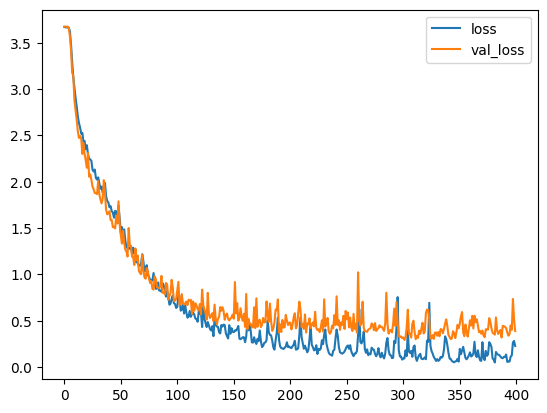

In [30]:
#loss:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show() 

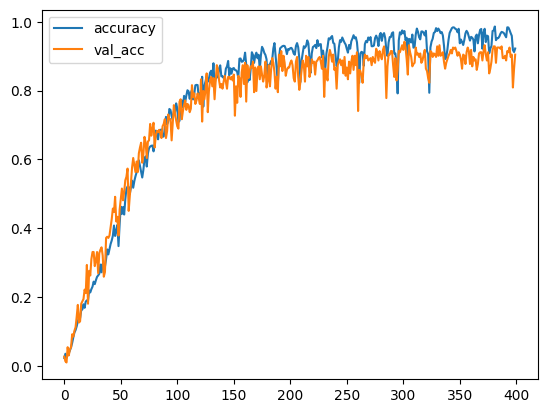

In [31]:
#accuracy:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.show() 

In [32]:
LSTM_model.save('models/LSTM_model.h5')